In [12]:
from qibo import gates, hamiltonians, set_backend
from qibo.models import Circuit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import json
from sympy.parsing.sympy_parser import parse_expr, standard_transformations, implicit_multiplication_application

In [2]:
from functions import *
from trotterize_adiabatic import *

In [49]:
# Small Hamiltonians are more efficiently simulated by the "numpy" backend.
# More costly simulations can be run by the "qibojit" backend.

set_backend('numpy')

[Qibo 0.2.4|INFO|2024-01-31 17:18:09]: Using numpy backend on /CPU:0


In [50]:
# Setup for the toy/illustrative instances to run.

folders = ['PO_sp500_part3_ra10_mult2']

instances = [1, 2, 4, 5, 11, 12, 13, 16, 20, 21]

qubits = [6]

types = ['Msdp', 'Ml1']

In [51]:
# Parameters of the simulation.

nqubits = qubits[0]
prob = 0
folder = 'data/'+folders[prob]
ins = 9

x = symbols(" ".join((f"x{i}" for i in range(0, nqubits))))

dict_x = {str(xx):xx for xx in x}
subs = substitutions(x, basis='x')

In [52]:
# Read the constrained problem instances, and their constraints in order to 
# get the minimum and maximum value of the objective function.

files_cons = get_filenames(folder, 'constrained', nqubits)
ham_cons = get_sym_obj(files_cons[instances[ins]], dict_x)
constraint = read_constraint(files_cons[instances[ins]], dict_x)

subspace = get_subspace(nqubits, x, constraint)
m, s_max, M, s_min = get_max_energy(subspace, ham_cons, nqubits, x)

In [53]:
# Aggregate all filenames of th echosen instances for both reformulations.

files = []

for typeM in types:
    files.append(get_filenames(folder, typeM, nqubits))

# The solutions of the different generated instances are collected as well.
solutions = get_filenames(folder, 'solution', nqubits)
sols = []
sol_bins = []
sol, sol_bin = get_solution(solutions[instances[ins]], nqubits)
sols.append(sol)
sol_bins.append(sol_bin)

In [54]:
# Create symbolix expressions from the problem instances and compile
# the Hamiltonians needed for adiabatic evolution.

hamils = []

for t in range(len(types)):
    sym_obj = get_sym_obj(files[t][instances[ins]], dict_x)
    ham = simplify(sym_obj.subs(subs))
    max_eig, min_eig = get_maxmin_eigenvalues(ham)
    ham = simplify((ham-min_eig)/(max_eig-min_eig))
    hamils.append(ham)

[Qibo 0.2.4|WARNING|2024-01-31 17:18:12]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-31 17:18:13]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [55]:
# Parameters used in the adiabatic evolution and Trotterization.
# These parameters will determine the number of two-qubit gates of the circuit.

T = 100
dt = 10
shots = 1000

In [56]:
# Build a Trotterized circuit for the adiabatic evolution of the M_l1 reformulation

ham_l1 = hamils[1]
qubo_l1 = Trotterize(nqubits, ham_l1, order=1)
c = qubo_l1.build_trotter_circuit(T, dt)

In [57]:
# Execution of the Trotterized circuit

initial_state = np.zeros(2**nqubits)
initial_state[0] = 1
result_q = c(initial_state=initial_state).state()
probs_q = c(initial_state=initial_state, nshots = shots)

In [58]:
print(f'Most probable state {np.abs(result_q).argmax()} with p = {(np.abs(result_q)**2).max()} \n')
print(f'Solution of the problem: {sol}')
print()
print(c.summary())

Most probable state 0 with p = 0.015624999999999997 

Solution of the problem: 7

Circuit depth = 12
Total number of gates = 72
Number of qubits = 6
Most common gates:
rz: 60
h: 6
measure: 6


In [59]:
# Once the simulation is successful, we parse the circuit and generate the json file
# needed to execute the circuit on an IonQ ion-trap quantum computer.
# (the parser does not recognize the Measurement gate, as in a real device Measurement are taken for granted.)

IonQ_parser(c, shots, "qpu.aria-1", f"qubo_trotterization_{prob}_{ins}_q", gateset="native")#, noise="aria-1")

Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Number of native 2 qubit gates: 0



In [60]:
# Build a Trotterized circuit for the adiabatic evolution of the M_sdp reformulation

ham_sdp = hamils[0]
qubo_sdp = Trotterize(nqubits, ham_sdp, order=1)
c = qubo_sdp.build_trotter_circuit(T, dt)

In [61]:
# Execution of the Trotterized circuit

initial_state = np.zeros(2**nqubits)
initial_state[0] = 1
result_o = c(initial_state=initial_state).state()
probs_o = c(initial_state=initial_state, nshots=shots)

In [62]:
print(f'Most probable state {np.abs(result_o).argmax()} with p = {(np.abs(result_o)**2).max()} \n')
print(f'Solution of the problem: {sol}')
print()
print(c.summary())

Most probable state 7 with p = 0.22471721479258047 

Solution of the problem: 7

Circuit depth = 102
Total number of gates = 282
Number of qubits = 6
Most common gates:
rxx: 150
rz: 60
rx: 60
h: 6
measure: 6


In [63]:
# Once the simulation is successful, we parse the circuit and generate the json file
# needed to execute the circuit on an IonQ ion-trap quantum computer.
# (the parser does not recognize the Measurement gate, as in a real device Measurement are taken for granted.)

IonQ_parser(c, shots, "qpu.aria-1", f"qubo_trotterization_{prob}_{ins}_o", gateset="native")#, noise="aria-1")

Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Gate skipped! Only H, RZ, RX and RXX supported at this stage!
Number of native 2 qubit gates: 151



In [64]:
# Aggregate and process the simulation results

pq = []
for i in range(2**nqubits):
    pq.append(probs_q.frequencies().get(format(i,f"0{nqubits}b"), 0)/shots)
    
po = []
for i in range(2**nqubits):
    po.append(probs_o.frequencies().get(format(i,f"0{nqubits}b"), 0)/shots)

In [65]:
ar_q = []
ar_q.append(get_ar(pq, m, M, ham_cons, nqubits, subspace=subspace, minimum=False, post=False))
ar_q.append(get_ar(pq, m, M, ham_cons, nqubits, subspace=subspace, minimum=True, post=False))
ar_q.append(get_ar(pq, m, M, ham_cons, nqubits, subspace=subspace, minimum=False, post=True))

ar_o = []
ar_o.append(get_ar(po, m, M, ham_cons, nqubits, subspace=subspace, minimum=False, post=False))
ar_o.append(get_ar(po, m, M, ham_cons, nqubits, subspace=subspace, minimum=True, post=False))
ar_o.append(get_ar(po, m, M, ham_cons, nqubits, subspace=subspace, minimum=False, post=True))

In [66]:
# Small tool to compute the success probability a circuit a given values for
# 1-qubit and 2-qubit gate errors and Measurement errors.

err1 = 0.9995
err2 = 0.9865
errM = 0.9950
print(success_probability(c, err1, err2, errM))

0.9138487012725327


# For results run from here!

(with the first two cells of the notebook)

In [3]:
# Here we parse the results extracted from an experimental run on IonQ's quantum computer

folders = ['PO_sp500_part3_ra10_mult2']

instances = [1, 3, 4, 5, 11, 12, 13, 16, 20, 21]

qubits = [6]

types = ['Msdp', 'Ml1']


nqubits = qubits[0]
prob = 0
folder = 'data/'+folders[prob]

x = symbols(" ".join((f"x{i}" for i in range(0, nqubits))))
dict_x = {str(xx):xx for xx in x}
subs = substitutions(x, basis='x')
files_cons = get_filenames(folder, 'constrained', nqubits)
solutions = get_filenames(folder, 'solution', nqubits)

sols = []
sol_bins = []
for ins in range(10):
    sol, sol_bin = get_solution(solutions[instances[ins]], nqubits)
    sols.append(sol)
    sol_bins.append(sol_bin)

In [36]:
files_cons = ['data/PO_sp500_part3_ra10_mult2/constrained/6/random11042_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random20142_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random27042_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random23742_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random27242_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random20342_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random19842_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random21542_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random10842_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random14342_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random1042_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random11442_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random25042_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random24742_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random19342_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random17242_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random2142_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random13942_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random1742_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random1542_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random25742_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random17842_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random21842_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random242_6.lp', 'data/PO_sp500_part3_ra10_mult2/constrained/6/random24342_6.lp']

In [37]:
solutions = ['data/PO_sp500_part3_ra10_mult2/solution/6/random11042_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random20142_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random27042_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random23742_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random27242_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random20342_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random19842_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random21542_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random10842_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random14342_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random1042_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random11442_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random25042_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random24742_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random19342_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random17242_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random2142_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random13942_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random1742_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random1542_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random25742_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random17842_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random21842_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random242_6.lp', 'data/PO_sp500_part3_ra10_mult2/solution/6/random24342_6.lp']

In [39]:
# Generate the minimum and maximum value of the original cost function in order to 
# retrieve the approximation ratio.

ms = []
s_maxs = []
Ms = []
s_mins = []
ham_cons_list = []
subspace_list = []
for ins in range(10):
    ham_cons = get_sym_obj(files_cons[instances[ins]], dict_x)
    ham_cons_list.append(ham_cons)
    constraint = read_constraint(files_cons[instances[ins]], dict_x)
    subspace = get_subspace(nqubits, x, constraint)
    subspace_list.append(subspace)
    m, s_max, M, s_min = get_max_energy(subspace, ham_cons, nqubits, x)
    ms.append(m)
    s_maxs.append(s_max)
    Ms.append(M)
    s_mins.append(s_min)

In [41]:
# Read the json files with the results taken from the IonQ quantum computer execution.

probs_o_list = []
probs_q_list = []
for ins in range(10):
    with open(f'results/qubo_trotterization_0_{ins}_q.json', 'rb') as f:
        data = json.load(f)
    freqs = {}
    for key in data.keys():
        freqs[format(int(key),f"0{nqubits}b")[::-1]] = data[key]
    probs = []
    for i in range(2**nqubits):
        probs.append(freqs.get(format(i,f"0{nqubits}b"), 0))
    probs_q_list.append(probs)
    with open(f'results/qubo_trotterization_0_{ins}_o.json', 'rb') as f:
        data = json.load(f)
    freqs = {}
    for key in data.keys():
        freqs[format(int(key),f"0{nqubits}b")[::-1]] = data[key]
    probs = []
    for i in range(2**nqubits):
        probs.append(freqs.get(format(i,f"0{nqubits}b"), 0))
    probs_o_list.append(probs)


ar_o_list = [] # OurM experimental results
ar_q_list = [] # QiskM experimental results
ar_r_list = [] # Random sampling
probs_r_list = np.ones(2**nqubits)/(2**nqubits)
for ins in range(10):
    ar_o = []
    ar_o.append(get_ar(probs_o_list[ins], ms[ins], Ms[ins], ham_cons_list[ins], nqubits, subspace=subspace_list[ins], minimum=False, post=False))
    ar_o.append(get_ar(probs_o_list[ins], ms[ins], Ms[ins], ham_cons_list[ins], nqubits, subspace=subspace_list[ins], minimum=True, post=False))
    ar_o.append(get_ar(probs_o_list[ins], ms[ins], Ms[ins], ham_cons_list[ins], nqubits, subspace=subspace_list[ins], minimum=False, post=True))
    ar_o_list.append(ar_o)
    ar_q = []
    ar_q.append(get_ar(probs_q_list[ins], ms[ins], Ms[ins], ham_cons_list[ins], nqubits, subspace=subspace_list[ins], minimum=False, post=False))
    ar_q.append(get_ar(probs_q_list[ins], ms[ins], Ms[ins], ham_cons_list[ins], nqubits, subspace=subspace_list[ins], minimum=True, post=False))
    ar_q.append(get_ar(probs_q_list[ins], ms[ins], Ms[ins], ham_cons_list[ins], nqubits, subspace=subspace_list[ins], minimum=False, post=True))
    ar_q_list.append(ar_q)
    ar_r = []
    ar_r.append(get_ar(probs_r_list, ms[ins], Ms[ins], ham_cons_list[ins], nqubits, subspace=subspace_list[ins], minimum=False, post=False))
    ar_r.append(get_ar(probs_r_list, ms[ins], Ms[ins], ham_cons_list[ins], nqubits, subspace=subspace_list[ins], minimum=True, post=False))
    ar_r.append(get_ar(probs_r_list, ms[ins], Ms[ins], ham_cons_list[ins], nqubits, subspace=subspace_list[ins], minimum=False, post=True))
    ar_r_list.append(ar_r)
    
psol_o_list = []
psol_q_list = []
for ins in range(10):
    psol_o_list.append(probs_o_list[ins][sols[ins]])
    psol_q_list.append(probs_q_list[ins][sols[ins]])

In [42]:
# Code for the experimental plots shown in Fig. (3) in the original publication.

In [43]:
Do = [[float(i) for i in np.array(ar_o_list)[:,2]]]#, [float(i) for i in np.array(ar_o_list)[:,2]]]
Dq = [[float(i) for i in np.array(ar_q_list)[:,2]]]#, [float(i) for i in np.array(ar_q_list)[:,2]]]
Dr = [[float(i) for i in np.array(ar_r_list)[:,2]]]
xx = [1]

In [44]:
psol_o_list

[0, 0.148, 0.185, 0.003, 0.171, 0, 0, 0, 0.003, 0]

In [58]:
import matplotlib as matp

matp.rcParams['mathtext.fontset'] = 'stix'
matp.rcParams['font.family'] = 'STIXGeneral'
#matp.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
M_strategies = [r"$M_{SDP}$", r"$M_{l_1}$"]

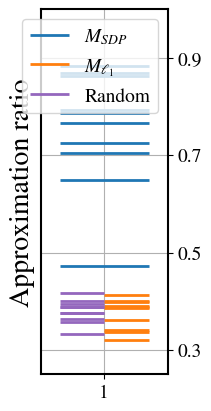

In [90]:
plt.rcParams.update({'font.size':14})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


fig, ax = plt.subplots(figsize=(2,4), constrained_layout=True)
ax.grid()

ax.eventplot(Do, orientation="vertical", lineoffsets=xx, linewidth=2, linelength=0.7, colors='C0', label='$M_{SDP}$')
ax.eventplot(Dq, orientation="vertical", lineoffsets=[1.175], linewidth=2, linelength=0.35, colors='C1', label= '$M_{\ell_1}$')
#ax.eventplot(Do, orientation="vertical", lineoffsets=xx, linewidth=2, linelength=0.7, colors='C0')
#ax.eventplot(Dq, orientation="vertical", lineoffsets=[1.175], linewidth=2, linelength=0.35, colors='C1')
ax.eventplot(Dr, orientation="vertical", lineoffsets=[.825], linewidth=2, linelength=0.35, colors='C4', label= 'Random')

ax.set_ylabel(r'Approximation ratio', size=20)
ax.yaxis.tick_right()

ax.set(xlim=(0.5, 1.5), xticks=(np.arange(1, 2, 1)),
       ylim=(0.25, 1), yticks=np.arange(0.3, 1, 0.2))
#ax.set_xticklabels(['Portfolio Optimization'])
plt.legend(loc='best')
plt.show()
fig.savefig(f'ar_comparison_oqr.svg', dpi=300, bbox_inches='tight')

In [10]:
x_range = np.arange(2**nqubits)

Text(0.5, 1.0, 'Result of Trotterization of Adiabatic Evolution')

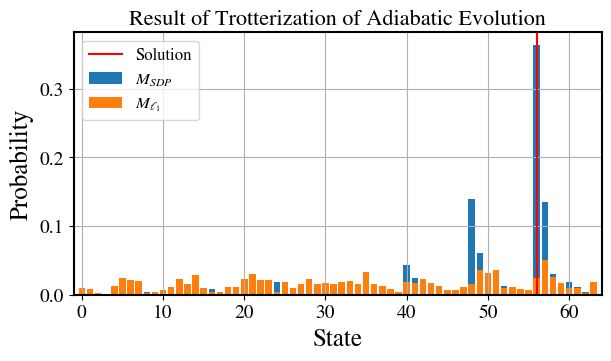

In [11]:
plt.rcParams.update({'font.size':14})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

fig = plt.figure(figsize=(6,3.5), constrained_layout=True)
plt.grid()

#plt.bar(x_range, probs_r_list, width=.8, align='center', color='C2', label=r'Rand')
plt.bar(x_range, probs_o_list[9], width=.8, align='center', color='C0', label=r'$M_{SDP}$')
plt.bar(x_range, probs_q_list[9], width=.8, align='center', color='C1', label=r'$M_{\ell_1}$')


plt.xlim([-1, 64])
plt.axvline(x=56, color='r', linestyle='-', label='Solution')
plt.legend(fontsize=12)
plt.xlabel(r'State', fontsize=18)
plt.ylabel(r'Probability', fontsize=18)
plt.title(r'Result of Trotterization of Adiabatic Evolution', fontsize=16)

#fig.savefig(f'results_ionq_compare.pdf', dpi=400, bbox_inches='tight')